In [17]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
from tqdm import tqdm

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score
from datetime import datetime

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from inference.models import EmotionBinEstimatorModel

In [18]:
SIZE=48
BATCH_SIZE=128
NUM_CLASSES=3
EPOCHS=80
LR=0.0005

TRAIN_DATASET_PATH="../data/data_fer_bin/train"
TEST_DATASET_PATH="../data/data_fer_bin/test"
LOG_PATH="../../logs/emotion_bin"
MODEL_PATH="../../models/emotion_bin_model_torch.pth"
WEIGHTS_PATH="../../models/emotion_bin_model_weights.pth"
TEST_IMAGE_PATH="../data/face_recognition_images/person2.3.jpg"
TIME_FORMAT="%d-%m-%Y; %H:%M:%S"
CLASS_LABELS  = ['negative', 'neutral', 'positive']

In [19]:
transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EmotionBinEstimatorModel(NUM_CLASSES).to(device)

In [3]:
class FERDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.root_dir = directory
        self.transform = transform
        self.images = []
        self.labels = []

        self.label_dict = {"negative": 0, "neutral": 1, "positive": 2}

        for label in os.listdir(directory):
            label_path = os.path.join(directory, label)
            if os.path.isdir(label_path):
                for img_file in os.listdir(label_path):
                    self.images.append(os.path.join(label_path, img_file))
                    self.labels.append(self.label_dict[label])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.images[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
train_dataset = FERDataset(directory=TRAIN_DATASET_PATH, transform=transform)
test_dataset = FERDataset(directory=TEST_DATASET_PATH, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
loss_fun = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [7]:
writer = SummaryWriter(log_dir=LOG_PATH + "/" + datetime.now().strftime(TIME_FORMAT))

for epoch in tqdm(range(EPOCHS)):  # проход по датасету несколько раз
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fun(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        writer.add_scalar('Metrics/epoch_loss', running_loss  / len(train_loader), epoch)
    
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.tolist())
            all_labels.extend(labels.tolist())
            
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    writer.add_scalar('Metrics/precision', precision, epoch)
    writer.add_scalar('Metrics/recall', recall, epoch)
    writer.add_scalar('Metrics/f1', f1, epoch)
print('Finished Training')

100%|██████████| 80/80 [1:23:36<00:00, 62.70s/it]

Finished Training


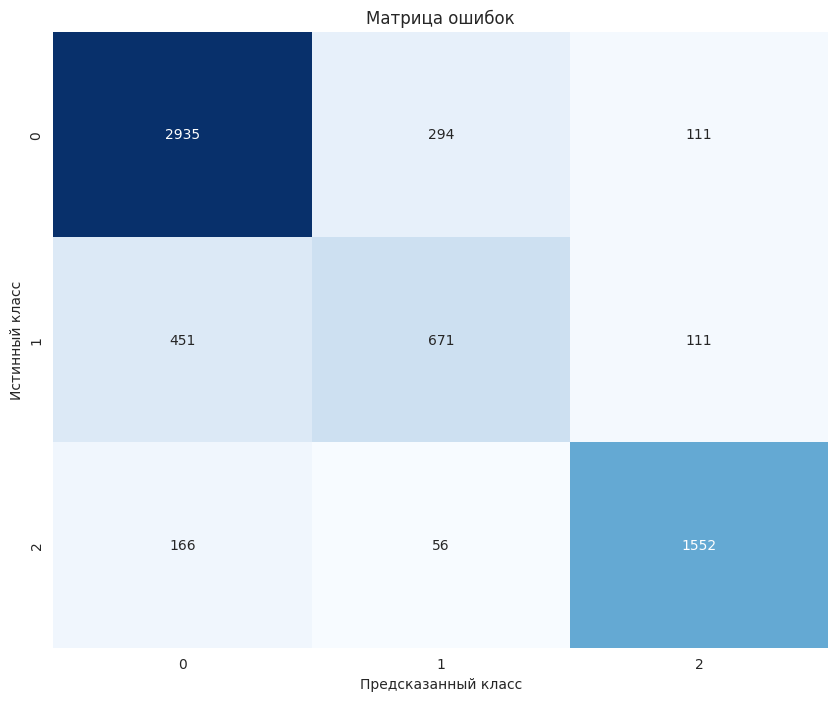

In [8]:
# Функция для вычисления предсказаний
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.tolist())
            all_labels.extend(labels.tolist())
    return all_labels, all_preds

# Получение предсказаний на валидационном наборе
all_labels, all_preds = get_predictions(model, test_loader)

conf_matrix = confusion_matrix(all_labels, all_preds)

# Визуализация матрицы ошибок с использованием seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

In [9]:
torch.save(model, MODEL_PATH)
torch.save(model.state_dict(), WEIGHTS_PATH)

In [21]:
# model = torch.load(MODEL_PATH)
model.load_state_dict(torch.load(WEIGHTS_PATH))
model.eval()

image = Image.open(TEST_IMAGE_PATH)
image = image.convert('L')
image = transform(image).to(device)
image = image.unsqueeze(0)

with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)
    predicted_emotion = predicted.item()

print(f'Predicted Emotion: {predicted_emotion}')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/vorkov/Workspace/EDA/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_29005/982729094.py", line 12, in <module>
    output = model(image)
  File "/home/vorkov/Workspace/EDA/venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/vorkov/Workspace/EDA/venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/vorkov/Workspace/EDA/inference/models.py", line 36, in forward
  File "/home/vorkov/Workspace/EDA/venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/vorkov/Workspace/EDA/venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line